<a href="https://colab.research.google.com/github/akivaadler/Self-Driving-Cars-Project/blob/main/Lane_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive

drive.mount("/content/gdrive", force_remount=True)

Mounted at /content/gdrive


In [ ]:
#!pip install kaggle

In [ ]:
import tensorflow as tf 
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Activation, Input, Conv2D, MaxPooling2D, BatchNormalization, Conv2DTranspose, concatenate
from tensorflow.keras.models import Model, load_model
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model, load_model

In [ ]:
# Create a function to iterate over all the direcory paths where our data are located (list in 2.1.1.) and return the list of the image paths in those directories

def list_image_paths(directory_paths):
    image_paths = []

    for directory in directory_paths:
        image_filenames = os.listdir(directory)
        sorted_image_filenames = sorted(image_filenames)
 
        for image_filename in sorted_image_filenames:
            image_paths.append(directory + image_filename)
            
    return image_paths

In [ ]:
import tensorflow as tf

device_name = tf.test.gpu_device_name()

if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
else:
  print(tf.__version__)
  print(tf.test.gpu_device_name())
  print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
  print('Found GPU at: {}'.format(device_name))

2.7.0
/device:GPU:0
Num GPUs Available:  1
Found GPU at: /device:GPU:0


In [ ]:
# Create a function to read image and mask paths and return equivalent arrays

def read_image(image_path, mask_path):
    
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, (256, 256), method='nearest')

    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=3)
    mask = tf.math.reduce_max(mask, axis=-1, keepdims=True)
    mask = tf.image.resize(mask, (256, 256), method='nearest')
    
    return image, mask

In [ ]:
# Create a data generator function to read and load images and masks in batches

def data_generator(image_paths, mask_paths, buffer_size, batch_size):
    
    image_list = tf.constant(image_paths) 
    mask_list = tf.constant(mask_paths)
    dataset = tf.data.Dataset.from_tensor_slices((image_list, mask_list))
    dataset = dataset.map(read_image, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.cache().shuffle(buffer_size).batch(batch_size).prefetch(tf.data.AUTOTUNE)
    
    return dataset

In [ ]:
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.layers import Activation, Input, Conv2D, MaxPooling2D, BatchNormalization, Conv2DTranspose, concatenate
from tensorflow.keras.models import Model, load_model

In [ ]:
# Define a function for an encoding block (This function will return the next layer output and the skip connection output for the corresponding block in the model)

def encoding_block(inputs, filters, dropout_probability=0, max_pooling=True):

    """
    Convolutional encoding/downsampling block
    
    Arguments:
        inputs -- Input tensor
        filters -- Number of filters for the convolutional layers
        max_pooling -- Use MaxPooling2D to reduce the spatial dimensions of the output volume
    Returns: 
        next_layer, skip_connection --  Next layer and skip connection inputs 
    """
    
    C = Conv2D(filters, 3, padding="same", kernel_initializer="he_normal")(inputs)
    C = BatchNormalization()(C)
    C = Activation("relu")(C)

    C = Conv2D(filters, 3, padding="same", kernel_initializer="he_normal")(C)
    C = BatchNormalization()(C)
    C = Activation("relu")(C)

    skip_connection = C  # Set aside residual
    
    # if max_pooling is True, add a MaxPooling2D with 2x2 pool_size
    if max_pooling:
        next_layer = MaxPooling2D(pool_size=(2, 2))(C)        
    else:
        next_layer = C
            
    return next_layer, skip_connection

In [ ]:
# Define a function for a decoding block (This function will merge the skip-connection input with the previous layer, process it, and return an output)

def decoding_block(inputs, skip_connection_input, filters):
    """
    Convolutional decoding/upsampling block
    
    Arguments:
        inputs -- Input tensor from previous layer
        skip_connection_input -- Input tensor from previous skip layer
        filters -- Number of filters for the convolutional layers
    Returns: 
        C -- Tensor output
    """

    CT = Conv2DTranspose(filters, 3, strides=(2,2), padding="same", kernel_initializer="he_normal")(inputs)
    
    residual_connection = concatenate([CT, skip_connection_input], axis=3)

    C = Conv2D(filters, 3, padding="same", kernel_initializer="he_normal")(residual_connection)
    C = BatchNormalization()(C)
    C = Activation("relu")(C)
    
    C = Conv2D(filters, 3, padding="same", kernel_initializer="he_normal")(C)
    C = BatchNormalization()(C)
    C = Activation("relu")(C)    
  
    return C

In [ ]:
# Develop a model using both the encoding and decoding blocks output

def unet_model(input_size, filters, n_classes):
    """
    Unet model
    
    Arguments:
        input_size -- Input shape 
        filters -- Number of filters for the convolutional layers
        n_classes -- Number of output classes
    Returns: 
        model -- tf.keras.Model
    """
    inputs = Input(input_size)
        
    # Contracting Path (encoding)
    C1, S1 = encoding_block(inputs, filters, max_pooling=True)
    C2, S2 = encoding_block(C1, filters * 2, max_pooling=True)
    C3, S3 = encoding_block(C2, filters * 4, max_pooling=True)
    C4, S4 = encoding_block(C3, filters * 8, max_pooling=True)
    
    C5, S5 = encoding_block(C4, filters * 16, max_pooling=False)
    
    # Expanding Path (decoding)
    U6 = decoding_block(C5, S4, filters * 8)
    U7 = decoding_block(U6, S3,  filters * 4)
    U8 = decoding_block(U7, S2,  filters = filters * 2)
    U9 = decoding_block(U8, S1,  filters = filters)

    C10 = Conv2D(filters,
                 3,
                 activation='relu',
                 padding='same',
                 kernel_initializer='he_normal')(U9)

    # Add a Conv2D layer with n_classes filter, kernel size of 1 and a 'same' padding
    C11 = Conv2D(filters = n_classes, kernel_size = (1,1), activation='sigmoid', padding='same')(C10)
    
    model = Model(inputs=inputs, outputs=C11)

    return model

In [ ]:
# %matplotlib inline
# %config InlineBackend.figure_format = 'svg'

def plot_metric(history, metric):
    train_metrics = history.history[metric]
    val_metrics = history.history['val_'+metric]
    epochs = range(1, len(train_metrics) + 1)
    plt.plot(epochs, train_metrics)
    plt.plot(epochs, val_metrics)
    plt.title('Training and validation '+ metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend(["train_"+metric, 'val_'+metric])
    plt.show()

In [ ]:
# Create Segmentations/Masks of Images in our Dataset
def create_mask(dataset, model):
    true_masks, predicted_masks = [], []
    for images, masks in dataset:
        pred_masks = model.predict(images)
        pred_masks = tf.expand_dims(tf.argmax(pred_masks, axis=-1), axis=-1)
        true_masks.extend(masks)
        predicted_masks.extend(pred_masks)
        
    true_masks = np.array(true_masks)
    predicted_masks = np.array(predicted_masks)
        
    return true_masks, predicted_masks    

In [ ]:
# Evaluate Predicted Segmentations
def evaluate_model(true_masks, predicted_masks, n_classes, smooth = 1e-6):
    
    """
    Evaluates semantic segmentation model
    
    Argument:
        true_masks: ground truth segmentations
        predicted_masks: predicted segmentations
        n_classes: number of segmentation classes
        smooth: a minute float digit added to denominators to avoid error from a zero division
    
    Returns:
        class_wise_evaluations: a dictionary containing evaluation metric 
                                outputs the for each segmentation class 
        overall_evaluations: a dictionary containing evaluation metric 
                             outputs the for all segmentation classes
        """
    # Create empty lists to store evaluation metric outputs
    class_wise_true_positives, class_wise_true_negatives = [],[]
    class_wise_false_positives, class_wise_false_negatives = [],[]
    class_wise_precisions, class_wise_recalls = [],[] 
    class_wise_specificities, class_wise_ious = [],[] 
    class_wise_tdrs, class_wise_f1_scores = [],[]
    classes = []
            
    for clas in range(n_classes):
        true_positives, true_negatives, false_positives, false_negatives = 0,0,0,0
        precisions, recalls, specificities, ious, f1_scores, tdrs = 0,0,0,0,0,0        
        
        number_of_masks = true_masks.shape[0]
        
        for mask_id in range(number_of_masks):
            true_positive = np.sum(np.logical_and(true_masks[mask_id]==clas, predicted_masks[mask_id]==clas))
            true_negative = np.sum(np.logical_and(true_masks[mask_id]!=clas, predicted_masks[mask_id]!=clas))
            false_positive = np.sum(np.logical_and(true_masks[mask_id]!=clas, predicted_masks[mask_id]==clas))
            false_negative = np.sum(np.logical_and(true_masks[mask_id]==clas, predicted_masks[mask_id]!=clas))
            
            true_positives += true_positive
            true_negatives += true_negative
            false_positives += false_positive
            false_negatives += false_negative

        recall = round(true_positives/(true_positives + false_negatives + smooth), 2)
        precision = round(true_positives/(true_positives + false_positives + smooth), 2)
        specificity = round(true_negatives/(true_negatives + false_positives + smooth), 2)
        tdr = round((1 - (false_negatives/(true_positives + false_negatives + smooth))), 2)
        iou = round(true_positives/(true_positives + false_negatives + false_positives + smooth), 2)
        f1_score = round((2 * precision * recall)/(precision + recall + smooth), 2)
        
        class_wise_true_positives.append(true_positives)
        class_wise_true_negatives.append(true_negatives)
        class_wise_false_positives.append(false_positives)
        class_wise_false_negatives.append(false_negatives)
        class_wise_recalls.append(recall)
        class_wise_precisions.append(precision)
        class_wise_specificities.append(specificity)
        class_wise_ious.append(iou)
        class_wise_tdrs.append(tdr)
        class_wise_f1_scores.append(f1_score)
        classes.append("Class " + str(clas+1))
        # class_wise_pixel_accuracies.append(pixel_accuracy)
        
    total_true_positives = np.sum(class_wise_true_positives)
    total_true_negatives = np.sum(class_wise_true_negatives)
    total_false_positives = np.sum(class_wise_false_positives)
    total_false_negatives = np.sum(class_wise_false_negatives)
    mean_recall = round(np.average(np.array(class_wise_recalls)), 2)
    mean_precision = round(np.average(np.array(class_wise_precisions)), 2)
    mean_specificity = round(np.average(np.array(class_wise_specificities)), 2)
    mean_iou = round(np.average(np.array(class_wise_ious)), 2)
    mean_tdr = round(np.average(np.array(class_wise_tdrs)), 2)
    mean_f1_score = round(np.average(np.array(class_wise_f1_scores)), 2)    
         
    class_wise_evaluations = {"Class": classes,
                              "True Positive Pixels": class_wise_true_positives,
                              "True Negative Pixels": class_wise_true_negatives,
                              "False Positive Pixels": class_wise_false_positives,
                              "False Negative Pixels": class_wise_false_negatives,
                              "Recall": class_wise_recalls,
                              "Precision": class_wise_precisions,
                              "Specificity": class_wise_specificities,
                              "IoU": class_wise_ious,
                              "TDR": class_wise_tdrs,
                              "F1-Score": class_wise_f1_scores}

    overall_evaluations = {"Class": "All Classes",
                        "True Positive Pixels": total_true_positives,
                        "True Negative Pixels": total_true_negatives,
                        "False Positive Pixels": total_false_positives,
                        "False Negative Pixels": total_false_negatives,
                        "Recall": mean_recall,
                        "Precision": mean_precision,
                        "Specificity": mean_specificity,
                        "IoU": mean_iou,
                        "TDR": mean_tdr,
                        "F1-Score": mean_f1_score}
    
    evaluations = {"Overall Evaluations": overall_evaluations, 
                   "Class-wise Evaluations": class_wise_evaluations}
    
    return evaluations

In [ ]:
import pandas as pd

In [ ]:
def show_evaluations(evaluations, 
                     metrics=["Recall", "Precision", "Specificity", "IoU", "TDR", "F1-Score"], 
                     class_list=None,
                     display_evaluations="All"):
    """
    Returns a pandas dataframe containing specified metrics
        
        Arguments:
            evaluations: evaluation output from the evaluate_model function
            metrics: a list containing one or more of the following metrics:
                     'True Positive', 'True Negative', 'False Positive', 'False Negative',
                     'Recall', 'Precision', 'Specificity', 'F1 Score', 'IoU', 'TDR'
            display_evaluations: one of 'All' to display both overall and class-wise evaluations,
                                 'Overall' to display only the overall evaluations,
                                 'Class-wise' to display only the classwise evaluations.
            class_list: list or tuple containing names of segmentation class.
    """
    
    # Split evaluations into overall and class-wise evaluations
    overall_evaluations = evaluations["Overall Evaluations"]
    class_wise_evaluations = evaluations["Class-wise Evaluations"]
    
    # Validate list of metrics 
    for metric_id in range(len(metrics)):
        metric = metrics[metric_id]
        if metric not in overall_evaluations:
            raise ValueError("'metrics argument' not properly defined. "
                            "Kindly create a list containing one or more of the following metrics: "
                             "'True Positive', 'True Negative', 'False Positive', 'False Negative', "
                             "'Recall', 'Precision', 'Specificity', 'F1-Score', 'IoU', 'TDR'") 
    
    # Check if class_list is none
    if class_list != None and all(isinstance(class_, str) for class_ in class_list):
        if len(class_list) == len(class_wise_evaluations["Class"]):
            class_list = [class_list]
        else:
            raise ValueError("class_list argument' not properly defined. " 
                             "List is either shorter or longer than segmentation classes") 
    else:
        class_list = [class_wise_evaluations["Class"]]                             
    
    # Extract data from the evaluations
    overall_data = [overall_evaluations["Class"]] + [overall_evaluations[metrics[metric_id]] for metric_id in range(len(metrics))]
    classwise_data = class_list + [class_wise_evaluations[metrics[metric_id]] for metric_id in range(len(metrics))]
    overall_data = np.array(overall_data).reshape(1,-1)
    classwise_data = np.array(classwise_data).transpose()
    
    # Determine the type of evaluation report to display
    if display_evaluations.lower() == "all":
        data = np.concatenate((overall_data, classwise_data), axis=0)
    elif display_evaluations.lower() == "overall":
        data = overall_data
    elif display_evaluations.lower() == "class-wise" or "classwise":
        data = classwise_data
    else:
        raise ValueError("Display argument are not properly defined."
                        "Kindly use 'All' to display both overall and class-wise evaluations."
                        "Use 'Overall' to display only the overall evaluations."
                        "Or use 'Class-wise' to display only the class-wise evaluations")

    
    # Create evaluation report as a pandas dataframe
    dataframe = pd.DataFrame(data)
    dataframe_titles = ["Class"] + metrics
    dataframe.columns = dataframe_titles
    # dataframe = dataframe.set_index(dataframe_titles[0], col_level=1)
    
    return dataframe

In [ ]:
# Create functions to preprocess selected images and display their true state, true mask and predicted mask

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Define a function to create new masks using our model
def create_mask_for_plot(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = tf.expand_dims(pred_mask, axis=-1)
    
    return pred_mask[0]

# Define a function to display outputs of this process: an input image, its true mask, and its predicted mask
def display(display_list, label_map):
    plt.figure(figsize=(18, 18))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        if i >= 1:
            plt.subplot(1, len(display_list), i + 1)
            plt.title(title[i])
            used_classes = np.unique(display_list[i])

            im = plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))            
            patches_1 = [mpatches.Patch(color=im.cmap(im.norm(int(cls))), label="{}".format(label_map[int(cls)])) for cls in used_classes]
            # put those patched as legend-handles into the legend
            plt.legend(handles=patches_1, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
            plt.axis("off")         
        else:
            plt.subplot(1, len(display_list), i+1)
            plt.title(title[i])
            plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))        
            plt.axis('off')
    plt.tight_layout()
    plt.show()

# Define a function to select images from a specified dataset and return the images, their true masks and their predicted masks
def show_predictions(dataset, model, label_map, num):
    """
    Displays the first image of each of the num batches
    """
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      display([image[0], mask[0], create_mask_for_plot(pred_mask)], label_map)

In [ ]:
%cd "/content/gdrive/MyDrive/ITC Data Science Course/Course/Final Project/Kaggle Datasets/Lane Detection for Carla Driving Simulator"

/content/gdrive/MyDrive/ITC Data Science Course/Course/Final Project/Kaggle Datasets/Lane Detection for Carla Driving Simulator


In [ ]:
import os

os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/MyDrive/ITC Data Science Course/Course/Final Project/Kaggle Datasets/Lane Detection for Carla Driving Simulator"

In [ ]:
# ! kaggle datasets download -d thomasfermi/lane-detection-for-carla-driving-simulator

In [ ]:
%ls

kaggle.json                                     train/
lane-detection-for-carla-driving-simulator.zip  train_label/
lane-detection-for-carla-model_2.h5             val/
lane-detection-for-carla-model.h5               val_label/
lane-detection-for-Carla-model.h5


In [ ]:
# ! unzip "lane-detection-for-carla-driving-simulator.zip"

In [ ]:
%ls

kaggle.json                                     train/
lane-detection-for-carla-driving-simulator.zip  train_label/
lane-detection-for-carla-model_2.h5             val/
lane-detection-for-carla-model.h5               val_label/
lane-detection-for-Carla-model.h5


In [ ]:
# Create paths to all directories in the train, train label, validation and validation labels

LANE_DATASET_PATH = "/content/gdrive/MyDrive/ITC Data Science Course/Course/Final Project/Kaggle Datasets/Lane Detection for Carla Driving Simulator/"

x_train_path = [LANE_DATASET_PATH + "train" + "/"]
y_train_path = [LANE_DATASET_PATH + "train_label" + "/"]

x_test_path = [LANE_DATASET_PATH + "val" + "/"]
y_test_path = [LANE_DATASET_PATH + "val_label" + "/"]

In [ ]:
# Create lists of train image and mask paths

train_image_paths = list_image_paths(x_train_path) 
train_labels_paths = list_image_paths(y_train_path)
number_of_train_images, number_of_train_labels = len(train_image_paths), len(train_labels_paths)

print(f"1. There are {number_of_train_images} images and {number_of_train_labels} labels in the train dataset")
print(f"2. An example of an train image path is: \n {train_image_paths[0]}")
print(f"3. An example of a train mask path is: \n {train_labels_paths[0]}")

1. There are 24600 images and 24600 labels in the train dataset
2. An example of an train image path is: 
 /content/gdrive/MyDrive/ITC Data Science Course/Course/Final Project/Kaggle Datasets/Lane Detection for Carla Driving Simulator/train/Town04_Clear_Noon_09_09_2020_14_57_22_frame_0.png
3. An example of a train mask path is: 
 /content/gdrive/MyDrive/ITC Data Science Course/Course/Final Project/Kaggle Datasets/Lane Detection for Carla Driving Simulator/train_label/Town04_Clear_Noon_09_09_2020_14_57_22_frame_0_label.png


In [ ]:
train_image_paths = [image for image in train_image_paths if "mir" not in image]
train_labels_paths = [image for image in train_labels_paths if "mir" not in image]

In [ ]:
train_image_paths[0:25]

['/content/gdrive/MyDrive/ITC Data Science Course/Course/Final Project/Kaggle Datasets/Lane Detection for Carla Driving Simulator/train/Town04_Clear_Noon_09_09_2020_14_57_22_frame_0.png',
 '/content/gdrive/MyDrive/ITC Data Science Course/Course/Final Project/Kaggle Datasets/Lane Detection for Carla Driving Simulator/train/Town04_Clear_Noon_09_09_2020_14_57_22_frame_0flip.png',
 '/content/gdrive/MyDrive/ITC Data Science Course/Course/Final Project/Kaggle Datasets/Lane Detection for Carla Driving Simulator/train/Town04_Clear_Noon_09_09_2020_14_57_22_frame_0gray.png',
 '/content/gdrive/MyDrive/ITC Data Science Course/Course/Final Project/Kaggle Datasets/Lane Detection for Carla Driving Simulator/train/Town04_Clear_Noon_09_09_2020_14_57_22_frame_0rot_10.png',
 '/content/gdrive/MyDrive/ITC Data Science Course/Course/Final Project/Kaggle Datasets/Lane Detection for Carla Driving Simulator/train/Town04_Clear_Noon_09_09_2020_14_57_22_frame_0rot_15.png',
 '/content/gdrive/MyDrive/ITC Data Scien

In [ ]:
from natsort import natsorted

In [ ]:
train_image_paths = natsorted(train_image_paths)
train_image_paths[0:25]

['/content/gdrive/MyDrive/ITC Data Science Course/Course/Final Project/Kaggle Datasets/Lane Detection for Carla Driving Simulator/train/Town04_Clear_Noon_09_09_2020_14_57_22_frame_0.png',
 '/content/gdrive/MyDrive/ITC Data Science Course/Course/Final Project/Kaggle Datasets/Lane Detection for Carla Driving Simulator/train/Town04_Clear_Noon_09_09_2020_14_57_22_frame_0flip.png',
 '/content/gdrive/MyDrive/ITC Data Science Course/Course/Final Project/Kaggle Datasets/Lane Detection for Carla Driving Simulator/train/Town04_Clear_Noon_09_09_2020_14_57_22_frame_0gray.png',
 '/content/gdrive/MyDrive/ITC Data Science Course/Course/Final Project/Kaggle Datasets/Lane Detection for Carla Driving Simulator/train/Town04_Clear_Noon_09_09_2020_14_57_22_frame_0rot_5.png',
 '/content/gdrive/MyDrive/ITC Data Science Course/Course/Final Project/Kaggle Datasets/Lane Detection for Carla Driving Simulator/train/Town04_Clear_Noon_09_09_2020_14_57_22_frame_0rot_10.png',
 '/content/gdrive/MyDrive/ITC Data Scienc

In [ ]:
train_labels_paths[0:25]

['/content/gdrive/MyDrive/ITC Data Science Course/Course/Final Project/Kaggle Datasets/Lane Detection for Carla Driving Simulator/train_label/Town04_Clear_Noon_09_09_2020_14_57_22_frame_0_label.png',
 '/content/gdrive/MyDrive/ITC Data Science Course/Course/Final Project/Kaggle Datasets/Lane Detection for Carla Driving Simulator/train_label/Town04_Clear_Noon_09_09_2020_14_57_22_frame_0_labelflip.png',
 '/content/gdrive/MyDrive/ITC Data Science Course/Course/Final Project/Kaggle Datasets/Lane Detection for Carla Driving Simulator/train_label/Town04_Clear_Noon_09_09_2020_14_57_22_frame_0_labelgray.png',
 '/content/gdrive/MyDrive/ITC Data Science Course/Course/Final Project/Kaggle Datasets/Lane Detection for Carla Driving Simulator/train_label/Town04_Clear_Noon_09_09_2020_14_57_22_frame_0_labelrot_10.png',
 '/content/gdrive/MyDrive/ITC Data Science Course/Course/Final Project/Kaggle Datasets/Lane Detection for Carla Driving Simulator/train_label/Town04_Clear_Noon_09_09_2020_14_57_22_frame_

In [ ]:
train_labels_paths = natsorted(train_labels_paths)
train_labels_paths[0:25]

['/content/gdrive/MyDrive/ITC Data Science Course/Course/Final Project/Kaggle Datasets/Lane Detection for Carla Driving Simulator/train_label/Town04_Clear_Noon_09_09_2020_14_57_22_frame_0_label.png',
 '/content/gdrive/MyDrive/ITC Data Science Course/Course/Final Project/Kaggle Datasets/Lane Detection for Carla Driving Simulator/train_label/Town04_Clear_Noon_09_09_2020_14_57_22_frame_0_labelflip.png',
 '/content/gdrive/MyDrive/ITC Data Science Course/Course/Final Project/Kaggle Datasets/Lane Detection for Carla Driving Simulator/train_label/Town04_Clear_Noon_09_09_2020_14_57_22_frame_0_labelgray.png',
 '/content/gdrive/MyDrive/ITC Data Science Course/Course/Final Project/Kaggle Datasets/Lane Detection for Carla Driving Simulator/train_label/Town04_Clear_Noon_09_09_2020_14_57_22_frame_0_labelrot_5.png',
 '/content/gdrive/MyDrive/ITC Data Science Course/Course/Final Project/Kaggle Datasets/Lane Detection for Carla Driving Simulator/train_label/Town04_Clear_Noon_09_09_2020_14_57_22_frame_0

In [ ]:
number_of_train_images, number_of_train_labels = len(train_image_paths), len(train_labels_paths)

print(f"1. There are {number_of_train_images} images and {number_of_train_labels} labels in the train dataset")

1. There are 21525 images and 21525 labels in the train dataset


In [ ]:
# Create lists of test image and labels paths

test_image_paths = list_image_paths(x_test_path) 
test_labels_paths = list_image_paths(y_test_path)
number_of_test_images, number_of_test_labels = len(test_image_paths), len(test_labels_paths)

print(f"1. There are {number_of_test_images} images and {number_of_test_labels} labels in the valid dataset")
print(f"2. An example of an train image path is: \n {test_image_paths[0]}")
print(f"3. An example of a train mask path is: \n {test_labels_paths[0]}")

1. There are 129 images and 129 labels in the valid dataset
2. An example of an train image path is: 
 /content/gdrive/MyDrive/ITC Data Science Course/Course/Final Project/Kaggle Datasets/Lane Detection for Carla Driving Simulator/val/Town04_Clear_Noon_09_09_2020_14_57_22_frame_100_validation_set.png
3. An example of a train mask path is: 
 /content/gdrive/MyDrive/ITC Data Science Course/Course/Final Project/Kaggle Datasets/Lane Detection for Carla Driving Simulator/val_label/Town04_Clear_Noon_09_09_2020_14_57_22_frame_100_validation_set_label.png


____SAMPLE IMAGE 1 DETAILS____
Type of the image :  <class 'imageio.core.util.Array'>
Shape of the image : (512, 1024, 3)
Image Height 512
Image Width 1024
Dimension of Image 3
Image size 1572864
Maximum RGB value in this image 244
Minimum RGB value in this image 0


____SAMPLE MASK 1 DETAILS____
Type of the image :  <class 'imageio.core.util.Array'>
Shape of the image : (512, 1024)
Image Height 512
Image Width 1024
Dimension of Image 2
Image size 524288
Maximum RGB value in this image 2
Minimum RGB value in this image 0
Found class: Unlabeled
Found class: Left Lane
Found class: Right Lane


colors [(0.267004, 0.004874, 0.329415, 1.0), (0.127568, 0.566949, 0.550556, 1.0), (0.993248, 0.906157, 0.143936, 1.0)]
used_classes [0, 1, 2]
____SAMPLE IMAGE 2 DETAILS____
Type of the image :  <class 'imageio.core.util.Array'>
Shape of the image : (512, 1024, 3)
Image Height 512
Image Width 1024
Dimension of Image 3
Image size 1572864
Maximum RGB value in this image 228
Minimum RGB value in this i

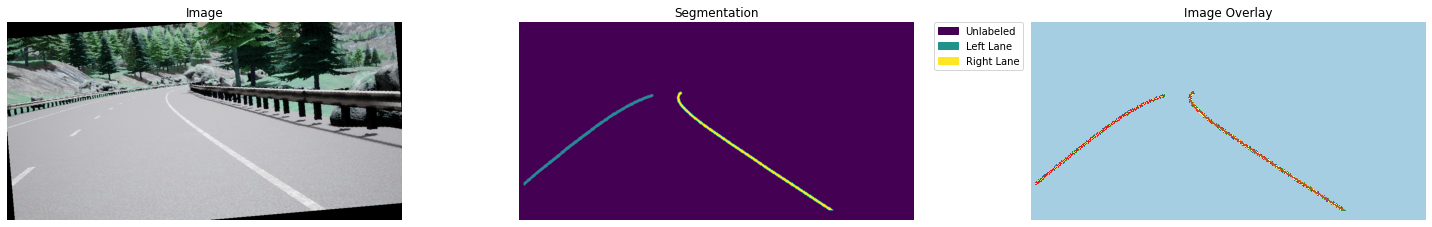

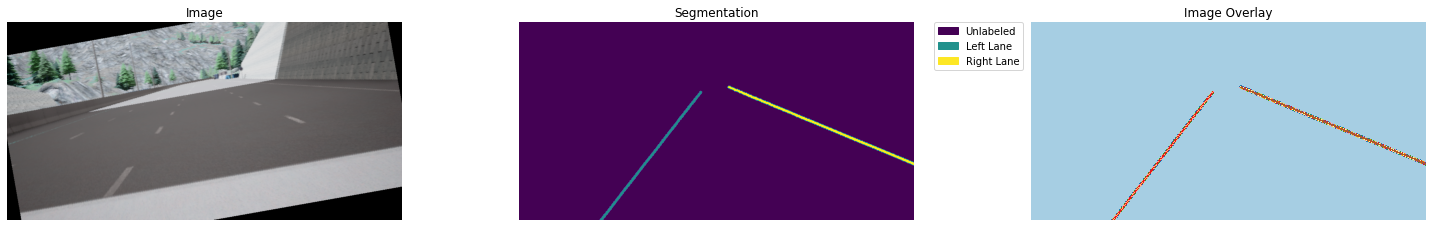

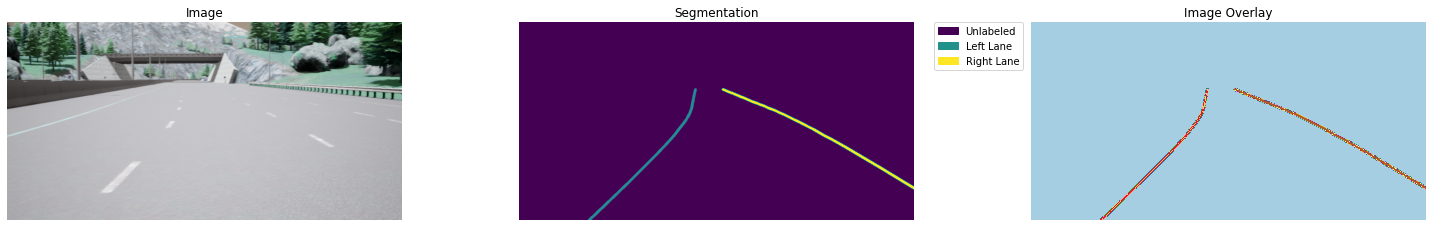

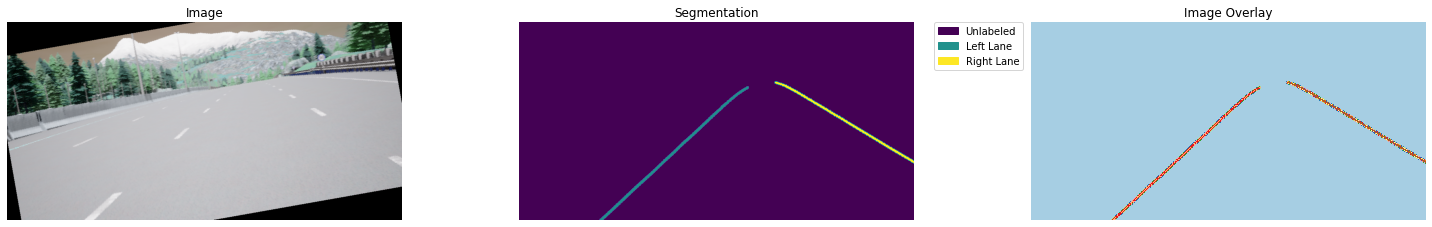

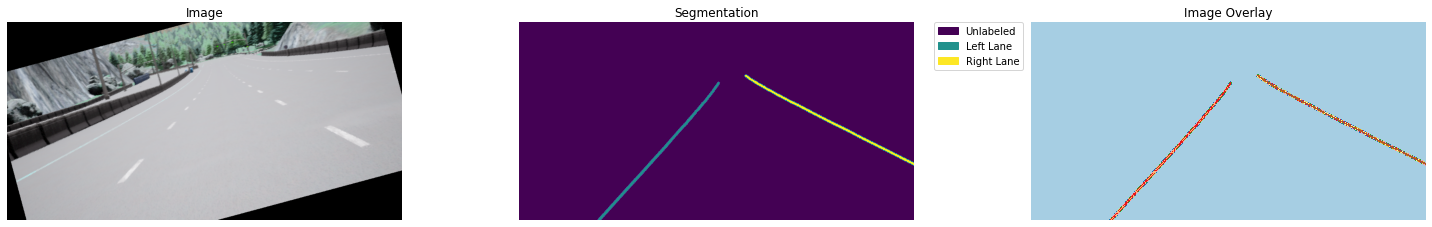

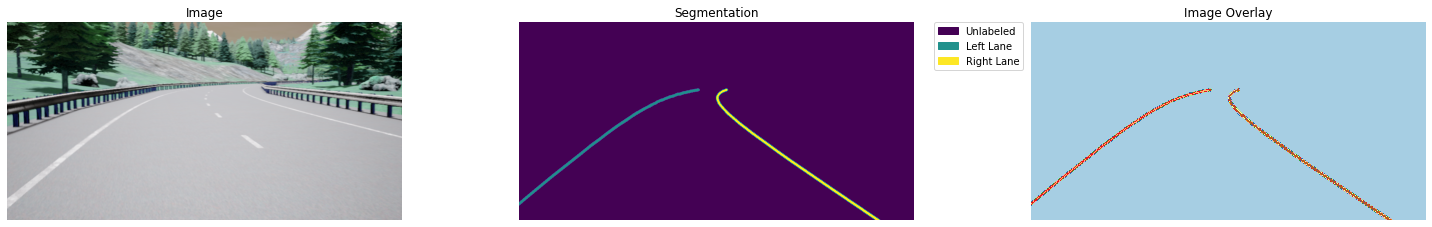

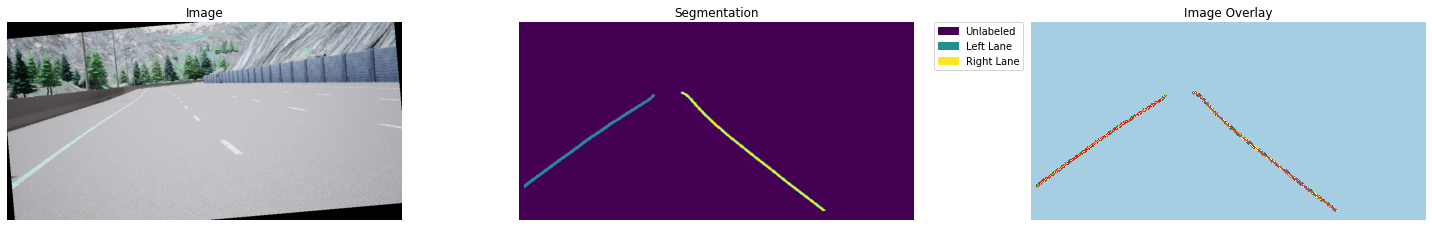

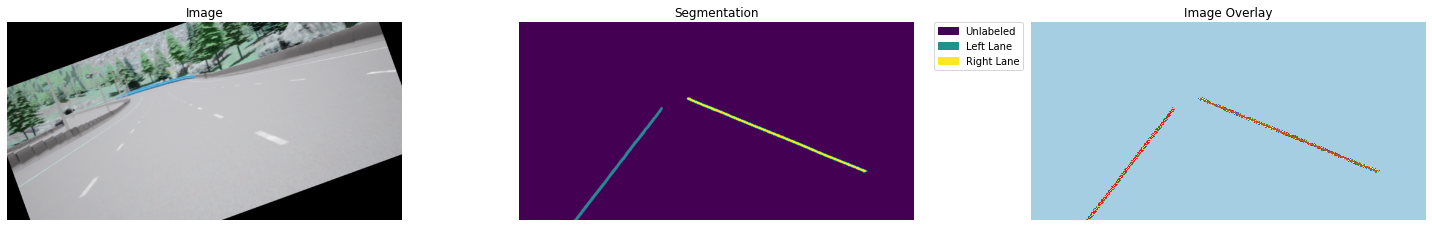

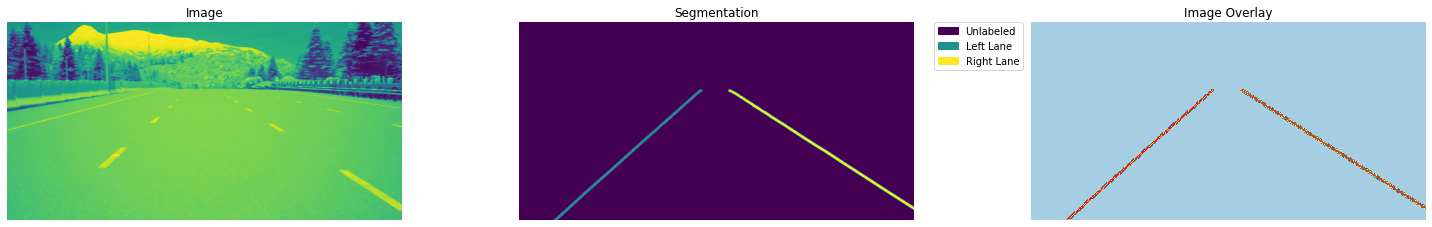

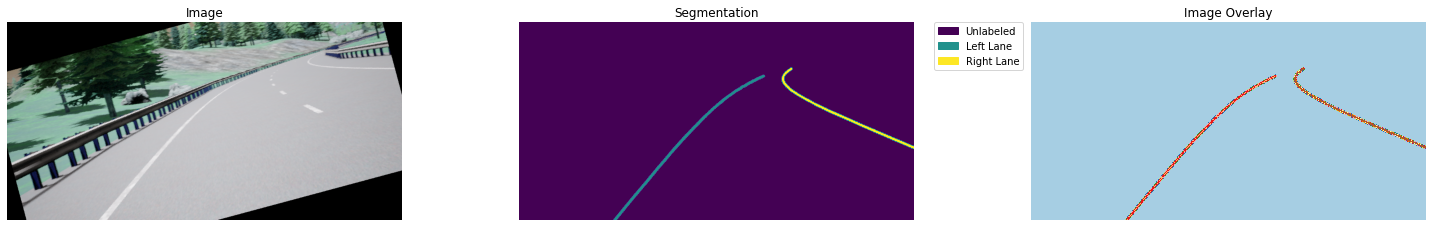

In [ ]:
# Preview random masked and unmasked images by reading them from their paths

import random
import imageio
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

number_of_lane_samples = len(train_image_paths)
lane_label_map = {0: 'Unlabeled', 1: 'Left Lane', 2: 'Right Lane'}

for i in range(10):
    N = random.randint(0, number_of_lane_samples - 1)

    img = imageio.imread(train_image_paths[N])
    mask = imageio.imread(train_labels_paths[N])
    # mask = np.array([max(mask[i, j]) for i in range(mask.shape[0]) for j in range(mask.shape[1])]).reshape(img.shape[0], img.shape[1])
    
    print(f'____SAMPLE IMAGE {i + 1} DETAILS____')
    print('Type of the image : ' , type(img)) 
    print('Shape of the image : {}'.format(img.shape)) 
    print('Image Height {}'.format(img.shape[0])) 
    print('Image Width {}'.format(img.shape[1])) 
    print('Dimension of Image {}'.format(img.ndim))
    print('Image size {}'.format(img.size)) 
    print('Maximum RGB value in this image {}'.format(img.max())) 
    print('Minimum RGB value in this image {}'.format(img.min()))
    print('\n')

    print(f'____SAMPLE MASK {i + 1} DETAILS____')
    print('Type of the image : ' , type(mask)) 
    print('Shape of the image : {}'.format(mask.shape)) 
    print('Image Height {}'.format(mask.shape[0])) 
    print('Image Width {}'.format(mask.shape[1])) 
    print('Dimension of Image {}'.format(mask.ndim))
    print('Image size {}'.format(mask.size)) 
    print('Maximum RGB value in this image {}'.format(mask.max())) 
    print('Minimum RGB value in this image {}'.format(mask.min()))

    used_classes = np.unique(mask)
    for cls in used_classes:
        print("Found class: {}".format(lane_label_map[cls]))

    print('\n')    

    fig, arr = plt.subplots(1, 3, figsize=(20, 8))
    arr[0].imshow(img)
    arr[0].set_title('Image')
    arr[0].axis("off")

    im = arr[1].imshow(mask)
    arr[1].set_title('Segmentation')
    arr[1].axis("off")
    # get the colors of the values, according to the colormap used by imshow
    colors = [im.cmap(im.norm(cls)) for cls in used_classes]
    # create a patch (proxy artist) for every color
    print("colors {}".format(colors))
    print("used_classes {}".format([int(cls) for cls in used_classes]))
    patches = [mpatches.Patch(color=colors[j], label="{}".format(lane_label_map[int(cls)])) for j, cls in enumerate(used_classes)]
    # put those patched as legend-handles into the legend
    arr[1].legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    
    arr[2].imshow(mask, cmap='Paired')
    arr[2].set_title('Image Overlay')
    arr[2].axis("off")

    fig.tight_layout()
    fig.show()

In [ ]:
from PIL import Image, ImageOps, ImageFilter

def process_img(list_of_image_paths, rot_range=25):
    if rot_range % 5 != 0:
        raise ValueError("Number must be divisable by 5. Please input a number that is a multiple of 5")
    else:
        for image_path in list_of_image_paths:
            open_img = Image.open(image_path)
            gray_img = ImageOps.grayscale(open_img)
            gray_img = gray_img.save(image_path.replace(".png",'') + "gray.png")
            flip_img = ImageOps.flip(open_img)
            flip_img = flip_img.save(image_path.replace(".png",'') + "flip.png")
            mir_img = ImageOps.mirror(open_img)
            mir_img = mir_img.save(image_path.replace(".png",'') + "mir.png")
            for i in range(5, rot_range, 5):
                rot_img = open_img.rotate(i)
                rot_img = rot_img.save(image_path.replace(".png",'') + f"rot_{i}.png")

In [ ]:
# NB NB NB NB NB NB
# Run this code only the first time to the lane dataset. IT augements the training data from around 3000 to 26000 images
# process_img(train_image_paths, rot_range=25)

In [ ]:
# NB NB NB NB NB NB
# Run this code only the first time to the lane dataset. IT augements the training data from around 3000 to 26000 images
# process_img(train_labels_paths, rot_range=25)

In [ ]:
# NB NB NB NB NB NB
# Only Run this code if the data augmentation has been run

# # Create lists of train image and mask paths

# train_image_paths = list_image_paths(x_train_path) 
# train_labels_paths = list_image_paths(y_train_path)
# number_of_train_images, number_of_train_labels = len(train_image_paths), len(train_labels_paths)

# print(f"1. There are {number_of_train_images} images and {number_of_train_labels} labels in the train dataset")
# print(f"2. An example of an train image path is: \n {train_image_paths[0]}")
# print(f"3. An example of a train mask path is: \n {train_labels_paths[0]}")

In [ ]:
# Split the image and mask paths into training, validation, and test sets
from sklearn.model_selection import train_test_split

X_lane_train = train_image_paths
y_lane_train = train_labels_paths
X_lane_test = test_image_paths
y_lane_test = test_labels_paths

# Keep part of the validation set as test set
X_lane_train, X_lane_val, y_lane_train, y_lane_val = train_test_split(X_lane_train, y_lane_train, test_size=0.15, random_state=0)

print(f'There are {len(X_lane_train)} images in the Training Set')
print(f'There are {len(X_lane_val)} images in the Validation Set')
print(f'There are {len(X_lane_test)} images in the Test Set')

There are 18296 images in the Training Set
There are 3229 images in the Validation Set
There are 129 images in the Test Set


In [ ]:
# Create data pipelines for the training, validation and test sets using both functions

batch_size = 64
buffer_size = 1024

lane_train_dataset = data_generator(X_lane_train, y_lane_train, buffer_size, batch_size)
lane_validation_dataset = data_generator(X_lane_val, y_lane_val, buffer_size, batch_size)
lane_test_dataset = data_generator(X_lane_test, y_lane_test, buffer_size, batch_size)

In [ ]:
img_height = 256
img_width = 256
num_channels = 3
filters_1 = 32
n_classes_lane = 3

lane_model = unet_model((img_height, img_width, num_channels), filters=filters_1, n_classes=n_classes_lane)
lane_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 32  896         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 256, 256, 32  128        ['conv2d[0][0]']                 
 alization)                     )                                                             

In [ ]:
lane_model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss',
                               patience=5, mode='min',
                               restore_best_weights=True
                               )
# reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=1e-1, patience=5, verbose=1, min_lr = 2e-6)
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.2,   
    patience=2, 
    min_lr=0.001,
    verbose=2
    )

# filepath = 'my_best_model.epoch{epoch:02d}-loss{val_loss:.2f}.hdf5'
filepath = 'lane-detection-for-carla-model.h5'

checkpoint = ModelCheckpoint(filepath=filepath, 
                             monitor='val_loss',
                             verbose=1, 
                             save_best_only=True,
                             mode='min')

In [ ]:
batch_size = 64
epochs = 20

In [ ]:
lane_history = lane_model.fit(lane_train_dataset, 
                    validation_data = lane_validation_dataset, 
                    epochs = epochs, 
                    verbose=1, 
                    callbacks = [checkpoint, early_stopping, reduce_lr], 
                    batch_size = batch_size, 
                    shuffle = True)

Epoch 1/20
286/286 [==============================] - ETA: 0s - loss: 0.0287 - accuracy: 0.9916
Epoch 00001: val_loss improved from inf to 0.02047, saving model to lane-detection-for-carla-model.h5
286/286 [==============================] - 1951s 6s/step - loss: 0.0287 - accuracy: 0.9916 - val_loss: 0.0205 - val_accuracy: 0.9935 - lr: 0.0010
Epoch 2/20
286/286 [==============================] - ETA: 0s - loss: 0.0086 - accuracy: 0.9963
Epoch 00002: val_loss improved from 0.02047 to 0.00758, saving model to lane-detection-for-carla-model.h5
286/286 [==============================] - 226s 792ms/step - loss: 0.0086 - accuracy: 0.9963 - val_loss: 0.0076 - val_accuracy: 0.9967 - lr: 0.0010
Epoch 3/20
286/286 [==============================] - ETA: 0s - loss: 0.0072 - accuracy: 0.9969
Epoch 00003: val_loss improved from 0.00758 to 0.00679, saving model to lane-detection-for-carla-model.h5
286/286 [==============================] - 226s 791ms/step - loss: 0.0072 - accuracy: 0.9969 - val_loss:

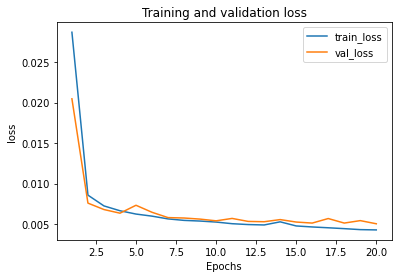

In [ ]:
plot_metric(lane_history, 'loss')

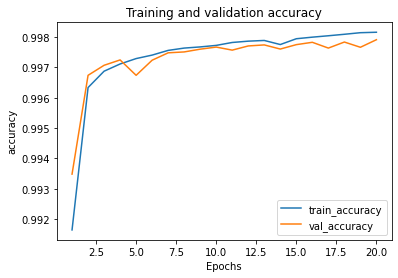

In [ ]:
plot_metric(lane_history, 'accuracy')

In [ ]:
# lane_model.save('lane-detection-for-carla-model.h5')

In [ ]:
# Load our model
lane_model = load_model('lane-detection-for-carla-model.h5')

In [ ]:
# Compute Model Accuracy

lane_train_loss, lane_train_accuracy = lane_model.evaluate(lane_train_dataset, batch_size = 64)
lane_validation_loss, lane_validation_accuracy = lane_model.evaluate(lane_validation_dataset, batch_size = 64)
lane_test_loss, lane_test_accuracy = lane_model.evaluate(lane_test_dataset, batch_size = 64)

3/3 [==============================] - 1s 123ms/step - loss: 0.0069 - accuracy: 0.9975


In [ ]:
print(f'Model Accuracy on the Training Dataset: {round(lane_train_accuracy * 100, 2)}%')
print(f'Model Accuracy on the Validation Dataset: {round(lane_validation_accuracy * 100, 2)}%')
print(f'Model Accuracy on the Test Dataset: {round(lane_test_accuracy * 100, 2)}%')

Model Accuracy on the Training Dataset: 99.82%
Model Accuracy on the Validation Dataset: 99.79%
Model Accuracy on the Test Dataset: 99.75%


In [ ]:
# lane_true_train_masks, lane_predicted_train_masks = create_mask(lane_train_dataset, lane_model)
lane_true_validation_masks, lane_predicted_validation_masks = create_mask(lane_validation_dataset, lane_model)

In [ ]:
# Evaluate predicted segmentations of the validation images

n_classes_lane = 3

LIST_OF_TAGS_LANE = ['Unlabeled', 'Left Lane', 'Right Lane']

model_evaluation_on_lane_validation_dataset = evaluate_model(lane_true_validation_masks, lane_predicted_validation_masks, n_classes=n_classes_lane)

show_evaluations(model_evaluation_on_lane_validation_dataset, 
                 metrics=["Recall", "Precision", "Specificity", "IoU", "TDR", "F1-Score"], 
                 class_list=LIST_OF_TAGS_LANE, 
                 display_evaluations="All")

Class Recall Precision Specificity   IoU   TDR F1-Score
0  All Classes   0.95      0.95        0.97   0.9  0.95     0.95
1    Unlabeled    1.0       1.0        0.92   1.0   1.0      1.0
2    Left Lane   0.92      0.92         1.0  0.85  0.92     0.92
3   Right Lane   0.92      0.93         1.0  0.86  0.92     0.92

In [ ]:
lane_true_test_masks, lane_predicted_test_masks = create_mask(lane_test_dataset, lane_model)

In [ ]:
# Evaluate predicted segmentations of the test images

n_classes_lane = 3

LIST_OF_TAGS_LANE = ['Unlabeled', 'Left Lane', 'Right Lane']

model_evaluation_on_lane_test_dataset = evaluate_model(lane_true_test_masks, lane_predicted_test_masks, n_classes_lane)

show_evaluations(model_evaluation_on_lane_test_dataset, 
                 metrics=["Recall", "Precision", "Specificity", "IoU", "TDR", "F1-Score"], 
                 class_list=LIST_OF_TAGS_LANE, 
                 display_evaluations="All")

Class Recall Precision Specificity   IoU   TDR F1-Score
0  All Classes   0.94      0.94        0.97  0.89  0.94     0.94
1    Unlabeled    1.0       1.0        0.91   1.0   1.0      1.0
2    Left Lane    0.9      0.91         1.0  0.83   0.9      0.9
3   Right Lane   0.91      0.92         1.0  0.84  0.91     0.91

In [ ]:
lane_label_map = ['Unlabeled', 'Left Lane', 'Right Lane']

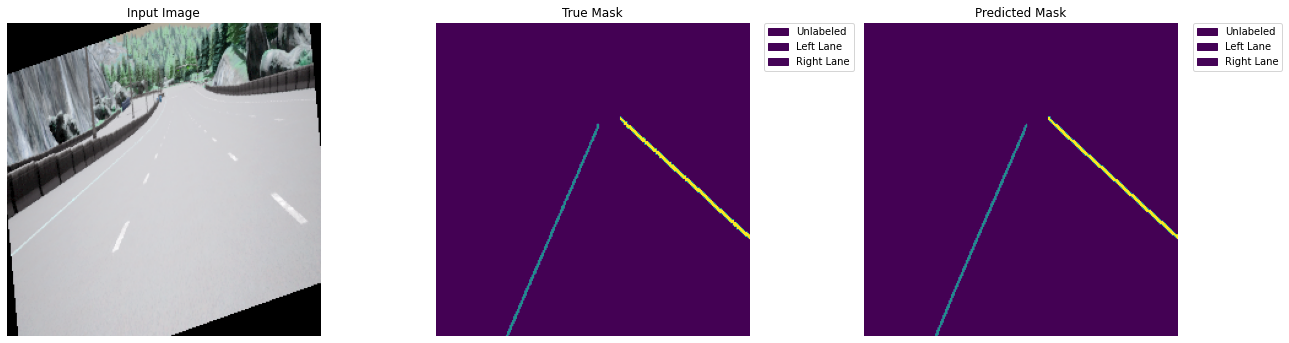

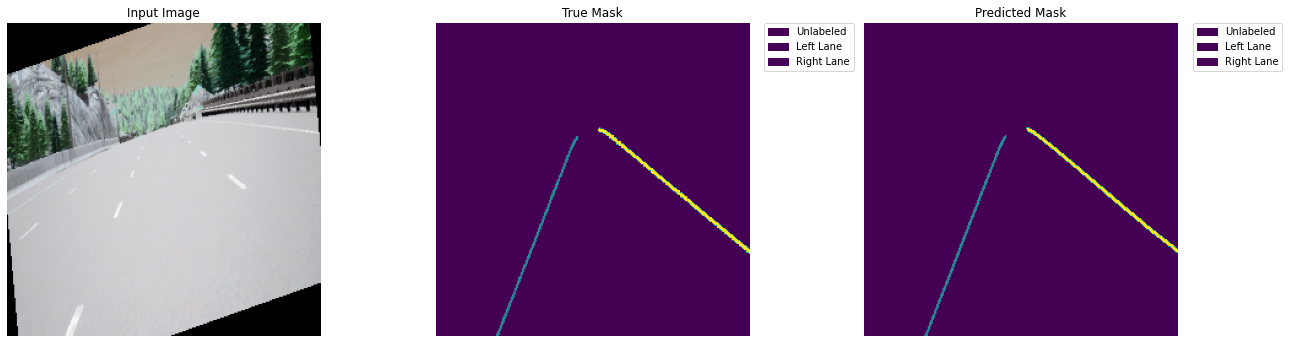

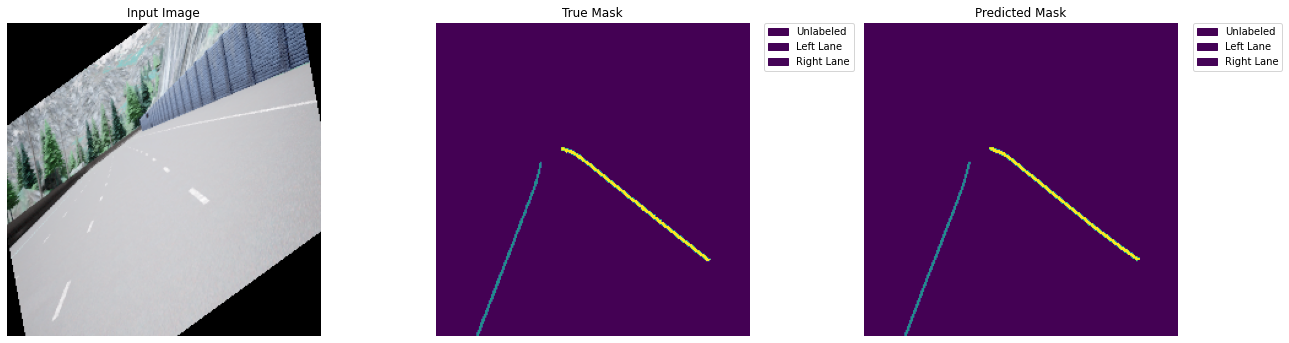

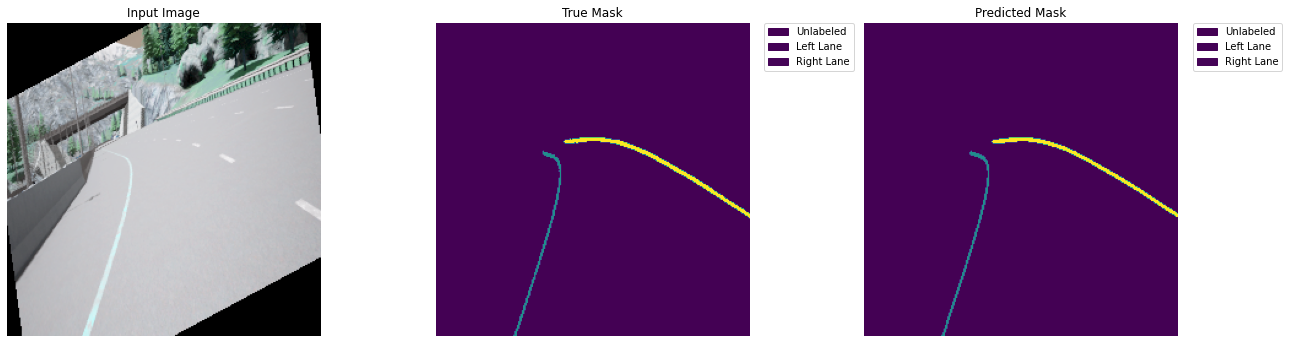

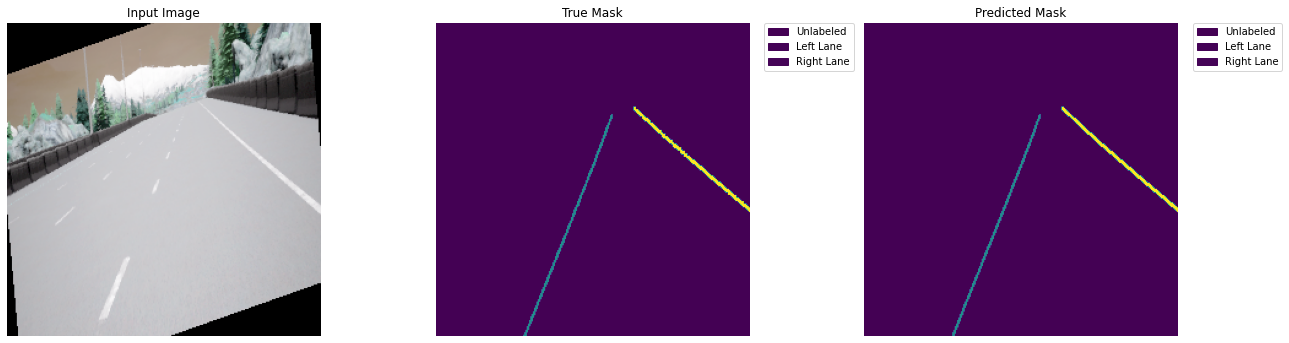

In [ ]:
# Predict and compare masks of images in the training set

show_predictions(lane_train_dataset, lane_model, lane_label_map, 5)

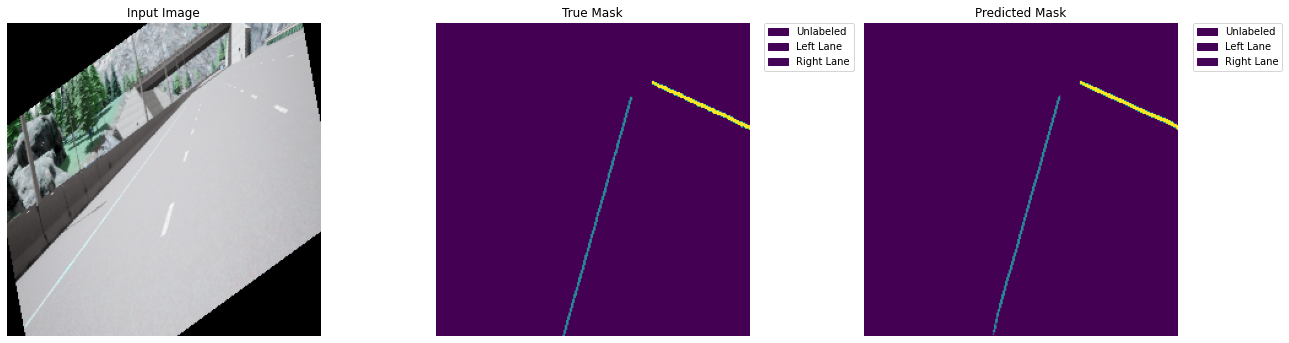

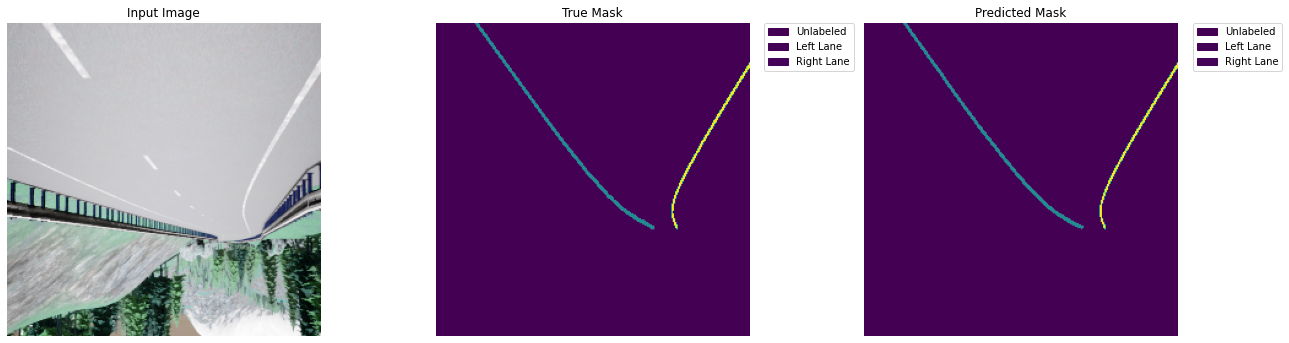

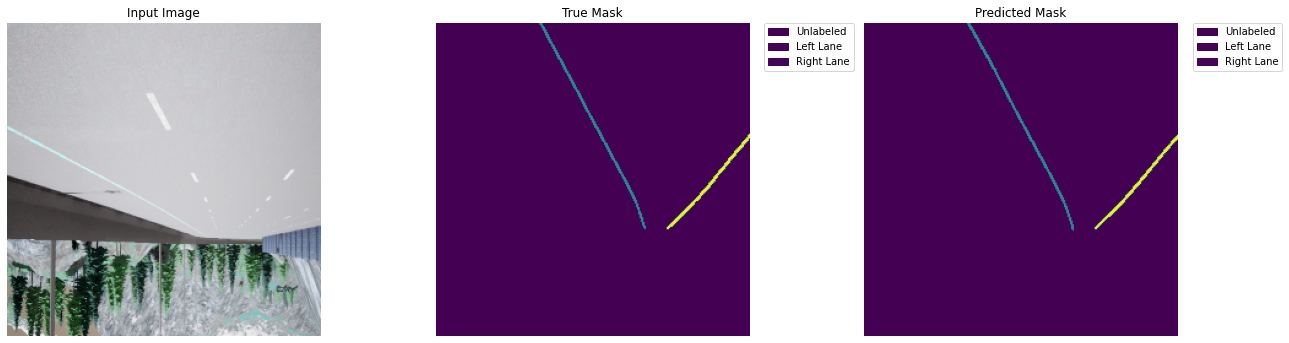

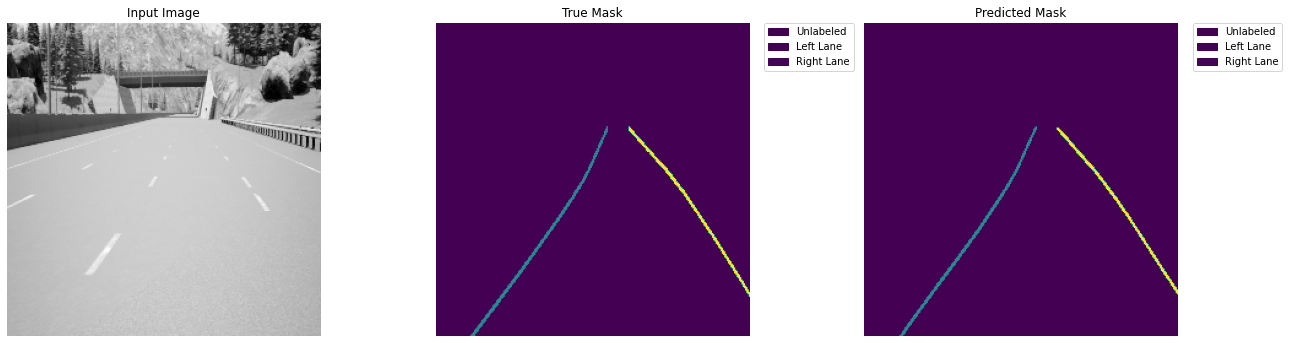

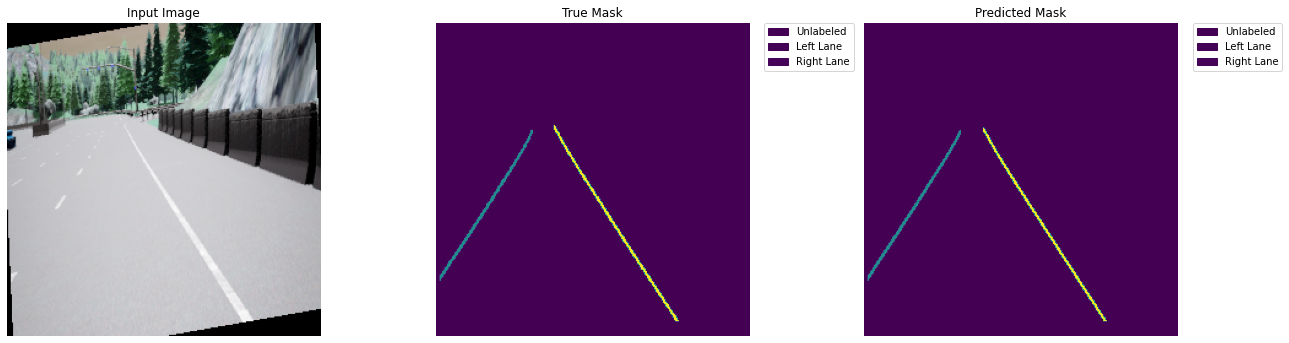

In [ ]:
# Predict and compare masks of images in the training set

show_predictions(lane_validation_dataset, lane_model, lane_label_map, 5)

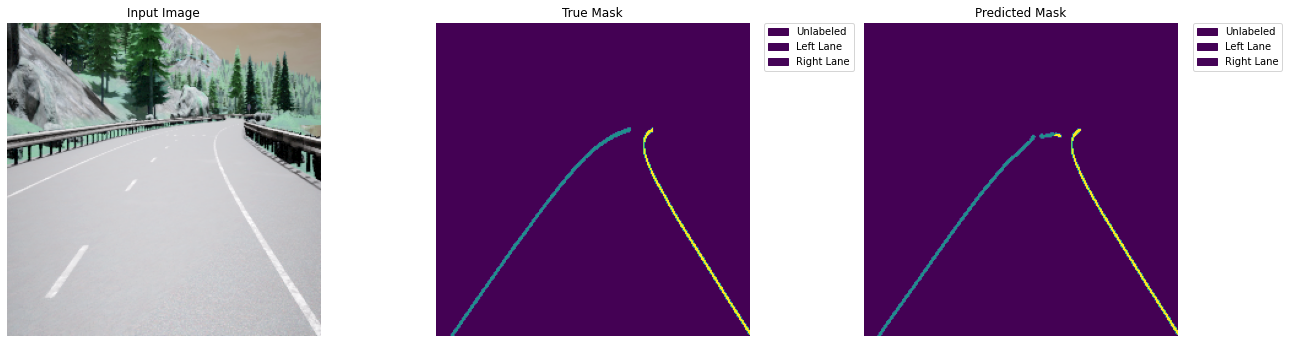

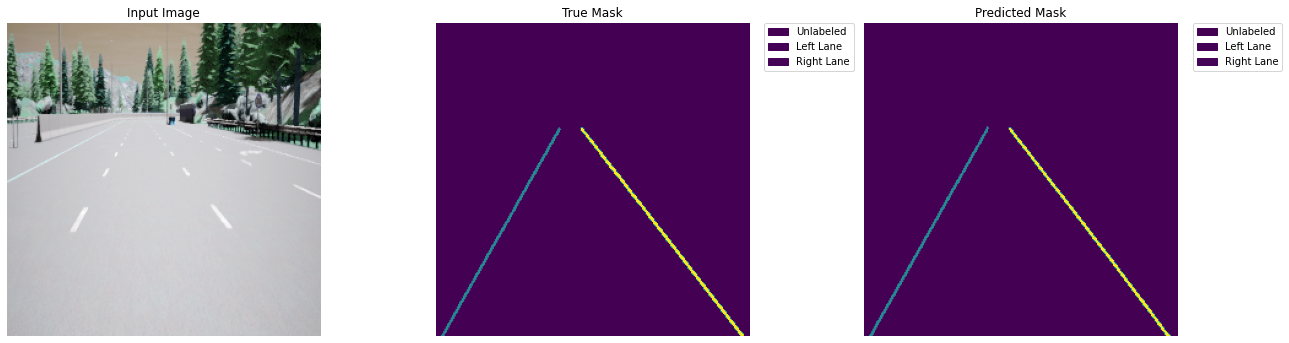

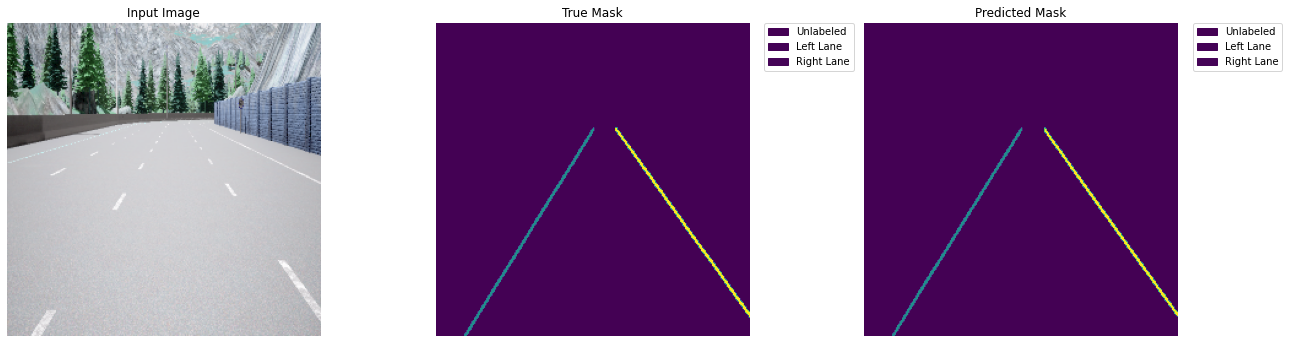

In [ ]:
# Predict and compare masks of images in the training set

show_predictions(lane_test_dataset, lane_model, lane_label_map, 10)

In [ ]:
# #@title
# # Importing necessary functions
# from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

# # we create two instances with the same arguments
# data_gen_args = dict(rotation_range=25,                     
#                      zoom_range=0.2,
#                      horizontal_flip=True,
#                      validation_split=0.20
#                      )

# image_datagen = ImageDataGenerator(**data_gen_args)
# mask_datagen = ImageDataGenerator(**data_gen_args)

# train_image_generator = image_datagen.flow_from_directory(
#     LANE_DATASET_PATH,
#     target_size=(256, 256),
#     color_mode='rgb',
#     batch_size=32,
#     class_mode=None,
#     classes=['train'],
#     subset='training'
# )

# train_mask_generator = mask_datagen.flow_from_directory(
#     LANE_DATASET_PATH,
#     target_size=(256, 256),
#     color_mode='rgb',
#     batch_size=32,
#     class_mode=None,
#     classes=['train_label'],
#     subset='training'
# # )

# # combine generators into one which yields image and masks
# train_generator = zip(train_image_generator, train_mask_generator)

In [ ]:
# #@title
# valid_image_generator = image_datagen.flow_from_directory(
#     LANE_DATASET_PATH,
#     target_size=(256, 256),
#     color_mode='rgb',
#     batch_size=32,
#     class_mode=None,
#     classes=['train'],
#     subset='validation'
# )

# valid_mask_generator = mask_datagen.flow_from_directory(
#     LANE_DATASET_PATH,
#     target_size=(256, 256),
#     color_mode='rgb',
#     batch_size=32,
#     class_mode=None,
#     classes=['train_label'],
#     subset='validation'
# )

# # combine generators into one which yields image and masks
# valid_generator = zip(valid_image_generator, valid_mask_generator)

In [ ]:
# #@title
# img_height = 256
# img_width = 256
# num_channels = 3
# filters_1 = 32
# n_classes_lane = 3

# lane_model_2 = unet_model((img_height, img_width, num_channels), filters=filters_1, n_classes=n_classes_lane)
# lane_model_2.summary()

In [ ]:
# #@title
# lane_model_2.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [ ]:
# #@title
# lane_2_history = lane_model_2.fit(
#     train_generator,
#     validation_data = valid_generator,
#     epochs = epochs,
#     steps_per_epoch=train_image_generator.samples//train_image_generator.batch_size,
#     validation_steps=valid_image_generator.samples//valid_image_generator.batch_size,
#     callbacks = [early_stopping, reduce_lr],
#     verbose=1
#     )

In [ ]:
# #@title
# plot_metric(lane_2_history, 'loss')

In [ ]:
# #@title
# plot_metric(lane_2_history, 'accuracy')

In [ ]:
# #@title
# lane_model_2.save('lane-detection-for-carla-model_2.h5')

In [ ]:
# #@title
# # Compute Model Accuracy

# lane_2_train_loss, lane_2_train_accuracy = lane_model_2.evaluate(lane_train_dataset, batch_size = 32)
# lane_2_validation_loss, lane_2_validation_accuracy = lane_model_2.evaluate(lane_validation_dataset, batch_size = 32)
# lane_2_test_loss, lane_2_test_accuracy = lane_model_2.evaluate(lane_test_dataset, batch_size = 32)

In [ ]:
# #@title
# print(f'Model Accuracy on the Training Dataset: {round(lane_2_train_accuracy * 100, 2)}%')
# print(f'Model Accuracy on the Validation Dataset: {round(lane_2_validation_accuracy * 100, 2)}%')
# print(f'Model Accuracy on the Test Dataset: {round(lane_2_test_accuracy * 100, 2)}%')

In [ ]:
# #@title
# lane_2_true_train_masks, lane_2_predicted_train_masks = create_mask(lane_train_dataset, lane_model_2)
# lane_2_true_validation_masks, lane_2_predicted_validation_masks = create_mask(lane_validation_dataset, lane_model_2)
# lane_2_true_test_masks, lane_2_predicted_test_masks = create_mask(lane_test_dataset, lane_model_2)

In [ ]:
# #@title
# # Evaluate predicted segmentations of the training images

# LIST_OF_TAGS_LANE = ['Unlabeled', 'Left Lane', 'Right Lane']

# model_evaluation_on_lane_train_dataset = evaluate_model(lane_2_true_train_masks, lane_2_predicted_train_masks, n_classes_lane)

# show_evaluations(model_evaluation_on_lane_train_dataset, 
#                  metrics=["Recall", "Precision", "Specificity", "IoU", "TDR", "F1-Score"], 
#                  class_list=LIST_OF_TAGS_LANE, 
#                  display_evaluations="All")

In [ ]:
# #@title
# # Evaluate predicted segmentations of the validation images
# model_evaluation_on_lane_validation_dataset = evaluate_model(lane_2_true_validation_masks, lane_2_predicted_validation_masks, n_classes=n_classes_lane)

# show_evaluations(model_evaluation_on_lane_validation_dataset, 
#                  metrics=["Recall", "Precision", "Specificity", "IoU", "TDR", "F1-Score"], 
#                  class_list=LIST_OF_TAGS_LANE, 
#                  display_evaluations="All")

In [ ]:
# #@title
# # Predict and compare masks of images in the training set

# show_predictions(lane_train_dataset, lane_model_2, lane_label_map, 5)

In [ ]:
# # Split the image and mask paths into training, validation, and test sets
# from sklearn.model_selection import train_test_split

# X_lane_train = train_image_paths
# y_lane_train = train_labels_paths
# X_lane_test = test_image_paths
# y_lane_test = test_labels_paths

# # Keep part of the validation set as test set
# X_lane_train, X_lane_val, y_lane_train, y_lane_val = train_test_split(X_lane_train, y_lane_train, test_size=0.15, random_state=0)

# print(f'There are {len(X_lane_train)} images in the Training Set')
# print(f'There are {len(X_lane_val)} images in the Validation Set')
# print(f'There are {len(X_lane_test)} images in the Test Set')

In [ ]:
# from PIL import Image, ImageOps, ImageFilter

# def process_img(list_of_image_paths, rot_range=25):
#     if rot_range % 5 != 0:
#         raise ValueError("Number must be divisable by 5. Please input a number that is a multiple of 5")
#     else:
#         for image_path in list_of_image_paths:
#             open_img = Image.open(image_path)
#             gray_img = ImageOps.grayscale(open_img)
#             gray_img = gray_img.save(image_path - ".png" + "gray.png")
#             flip_img = ImageOps.flip(open_img)
#             flip_img = flip_img.save(image_path - ".png" + "flip.png")
#             mir_img = ImageOps.mirror(open_img)
#             mir_img = mir_img.save(image_path - ".png" + "mir.png")
#             for i in range(5, rot_range, 5):
#                 rot_img = open_img.rotate(i)
#                 rot_img = rot_img.save(image_path - ".png" + f"rot_{i}.png")

In [ ]:
# # Create a data generator function to read and load images and masks in batches

# def data_generator(image_paths, mask_paths, buffer_size, batch_size):
    
#     image_list = tf.constant(image_paths) 
#     mask_list = tf.constant(mask_paths)
#     dataset = tf.data.Dataset.from_tensor_slices((image_list, mask_list))
#     dataset = dataset.map(read_image, num_parallel_calls=tf.data.AUTOTUNE)
#     dataset = dataset.cache().shuffle(buffer_size).batch(batch_size)
    
#     return dataset

In [ ]:
# # Create data pipelines for the training, validation and test sets using both functions

# batch_size = 32
# buffer_size = 500

# lane_train_dataset = data_generator(X_lane_train, y_lane_train, buffer_size, batch_size)
# lane_validation_dataset = data_generator(X_lane_val, y_lane_val, buffer_size, batch_size)
# lane_test_dataset = data_generator(X_lane_test, y_lane_test, buffer_size, batch_size)